In [1]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio
import pims
from skimage.measure import label, regionprops
from skimage.color import label2rgb
import scipy

In [10]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Culture_ClickChemistry/20190703_positivectrl_tnrunlabelled_star635p580secondaries_culture2_analyse/'
protein="TNR" #TNR,Agg,WFA,HABP

In [11]:
ecmchannelno=2
funcatchannelno=1
#autofluorescencechannelno=3

results = {"filename":[],
          "exp condition":[],
          "ecmchannelno":[],
          "funcatchannelno":[],
           #"autofluorescencechannelno":[],
           "Manual ECM spots mask":[],
           "Manual funcat spots mask":[]
           #"Manual autofluorescence spots mask":[]
          }
           
path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    if "_analyse" in str(filelist[i]):
        if "2019" in str(filelist[i]):
            if ("Pop" in str(filelist[i]))==False:
                if ("save" in str(filelist[i]))==False:
                    if filelist[i].endswith(".tif"): 
                        if str(filelist[i][:-12]) not in str(results["filename"]):
                            results["filename"].append(filelist[i][:-12])
                            results["exp condition"].append(filelist[i][:-12].split('/')[-2])
                            #channeldir="/".join(filelist[i][:-12].split("/")[:-1])
                            #exec(open(channeldir+"/channels.txt").read())
                            results["ecmchannelno"].append(ecmchannelno)
                            results["funcatchannelno"].append(funcatchannelno)
                            #results["autofluorescencechannelno"].append(autofluorescencechannelno)
                                        

## Loading a random image

Image name: 10_ExpControl
Experimental condition: TIF_imp


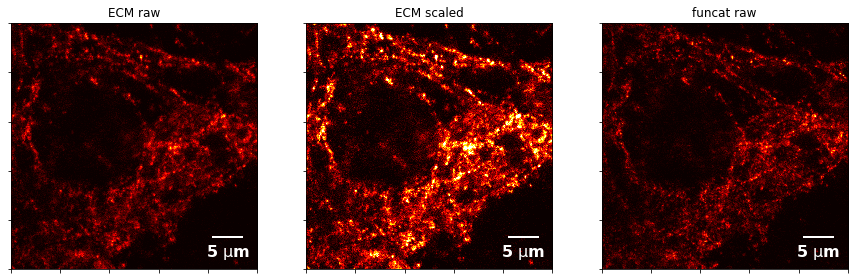

In [12]:
randomno=np.random.randint(1,len(results["filename"]))
ecm_channel_no=results["ecmchannelno"][randomno]
funcat_channel_no=results["funcatchannelno"][randomno]
#autofluorescence_channel_no=results["autofluorescencechannelno"][randomno]

ecm_image_name=results["filename"][randomno]+" Ch"+str(ecm_channel_no)+" {0}.tif"
funcat_image_name=results["filename"][randomno]+" Ch"+str(funcat_channel_no)+" {0}.tif"
#autofluorescence_image_name=results["filename"][randomno]+" Ch"+str(autofluorescence_channel_no)+" {0}.tif"

print("Image name:",results["filename"][randomno].split('/')[-1])
print("Experimental condition:",results["exp condition"][randomno])
ecm_image=pims.open(ecm_image_name)[0]
funcat_image=pims.open(funcat_image_name)[0]
#autofluorescence_image=pims.open(autofluorescence_image_name)[0]


   
figure=plt.figure(figsize=(15,15))
figure.add_subplot(131)
plt.imshow(ecm_image,interpolation='none',cmap='hot')
plt.title('ECM raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(40, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)
figure.add_subplot(132)
plt.imshow(ecm_image,interpolation='none',cmap='hot',vmin=3*np.min(ecm_image),vmax=0.4*np.max(ecm_image))
plt.title('ECM scaled')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(40, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    
plt.gca().add_artist(scalebar)

figure.add_subplot(133)
plt.imshow(funcat_image,interpolation='none',cmap='hot')
plt.title('funcat raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(40, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    
plt.gca().add_artist(scalebar)

## Find spots

### Manual

In [13]:
#make empty masks
for i in range(0,len(results["filename"])):
    results["Manual ECM spots mask"].append(np.nan)
    results["Manual funcat spots mask"].append(np.nan)
    #results["Manual autofluorescence spots mask"].append(np.nan)

### For ECM channel

In [14]:
import ipywidgets as widgets
from ipywidgets import interact
first=0

#load first image
#ecm_channel_no=results["ecmchannelno"][first]
ecm_image_name=results["filename"][first]+" Ch"+str(ecm_channel_no)+" {0}.tif"


ecm_image=pims.open(ecm_image_name)[0]
ecm_spots=deepcopy(ecm_image)
ecm_spots=ndi.median_filter(ecm_spots,size=5)

lower_man_threshold=np.min(ecm_spots)
upper_man_threshold=np.max(ecm_spots)

def f(Threshold,Manual_Threshold,Open,Close,Image_no):
    
    ii=Image_no
    ecm_channel_no=results["ecmchannelno"][ii]
    ecm_image_name=results["filename"][ii]+" Ch"+str(ecm_channel_no)+" {0}.tif"

    ecm_image=pims.open(ecm_image_name)[0]
    #bandpass (subtract gaussian filter)
    #lowpass = ndi.gaussian_filter(ecm_image, 3)
    #ecm_image = ecm_image - lowpass
    #ecm_image[ecm_image<0]=0
    
    ecm_spots=deepcopy(ecm_image)
    lower_man_threshold=np.min(ecm_spots)
    upper_man_threshold=np.max(ecm_spots)

    if Threshold=="Li":
        ecm_image_threshold=threshold_li(ecm_image)      
    if Threshold=="Otsu":
        ecm_image_threshold=threshold_otsu(ecm_image)
    if Threshold=="Manual":
        ecm_image_threshold=Manual_Threshold
    
    ecm_spots[ecm_spots<ecm_image_threshold]=0
    ecm_spots=ndi.binary_opening(ecm_spots,iterations=Open)
    ecm_spots=ndi.binary_closing(ecm_spots,iterations=Close)
    results["Manual ECM spots mask"][ii]=ecm_spots
    fig=plt.figure(figsize=(10,10))
    fig.add_subplot(121)
    plt.imshow(ecm_spots)
    plt.imshow(ecm_image,alpha=0.5,cmap='inferno')
    fig.add_subplot(122)
    plt.imshow(ecm_image,cmap='inferno')
    

#widgets
Threshold=widgets.Dropdown(options=["Li","Otsu","Manual"])
Manual_Threshold=widgets.IntSlider(min=lower_man_threshold,max=upper_man_threshold,step=1,value=lower_man_threshold)
Open=widgets.IntText(min=0,max=20,step=1,value=1)
Close=widgets.IntText(min=0,max=20,step=1,value=1)
Image_no=widgets.IntText(min=0,max=len(results["filename"]),value=0)

w=interact(f,Threshold=Threshold,Manual_Threshold=Manual_Threshold,Open=Open,Close=Close,
           Image_no=Image_no)

interactive(children=(Dropdown(description='Threshold', options=('Li', 'Otsu', 'Manual'), value='Li'), IntSlid…

### Backup manual spots for ecm

In [15]:
for image in range(0,len(results["filename"])):
    np.save(results["filename"][image]+'_ecm_spots_mask.npy',results["Manual ECM spots mask"][image])

### Make spots for funcat channel

In [16]:
import ipywidgets as widgets
from ipywidgets import interact
first=0

#load first image
#funcat_channel_no=results["funcatchannelno"][first]
funcat_image_name=results["filename"][first]+" Ch"+str(funcat_channel_no)+" {0}.tif"


funcat_image=pims.open(funcat_image_name)[0]
funcat_spots=deepcopy(funcat_image)
funcat_spots=ndi.median_filter(funcat_spots,size=5)

lower_man_threshold=np.min(funcat_spots)
upper_man_threshold=np.max(funcat_spots)

def f(Threshold,Manual_Threshold,Open,Close,Image_no):
    
    ii=Image_no
    funcat_channel_no=results["funcatchannelno"][ii]
    funcat_image_name=results["filename"][ii]+" Ch"+str(funcat_channel_no)+" {0}.tif"

    funcat_image=pims.open(funcat_image_name)[0]
    #bandpass (subtract gaussian filter)
    #lowpass = ndi.gaussian_filter(funcat_image, 3)
    #funcat_image = funcat_image - lowpass
    #funcat_image[funcat_image<0]=0
    
    funcat_spots=deepcopy(funcat_image)
    lower_man_threshold=np.min(funcat_spots)
    upper_man_threshold=np.max(funcat_spots)

    if Threshold=="Li":
        funcat_image_threshold=threshold_li(funcat_image)      
    if Threshold=="Otsu":
        funcat_image_threshold=threshold_otsu(funcat_image)
    if Threshold=="Manual":
        funcat_image_threshold=Manual_Threshold
    
    funcat_spots[funcat_spots<funcat_image_threshold]=0
    funcat_spots=ndi.binary_opening(funcat_spots,iterations=Open)
    funcat_spots=ndi.binary_closing(funcat_spots,iterations=Close)
    results["Manual funcat spots mask"][ii]=funcat_spots
    fig=plt.figure(figsize=(10,10))
    fig.add_subplot(121)
    plt.imshow(funcat_spots)
    plt.imshow(funcat_image,alpha=0.5,cmap='inferno')
    fig.add_subplot(122)
    plt.imshow(funcat_image,cmap='inferno')
    

#widgets
Threshold=widgets.Dropdown(options=["Li","Otsu","Manual"])
Manual_Threshold=widgets.IntSlider(min=lower_man_threshold,max=upper_man_threshold,step=1,value=lower_man_threshold)
Open=widgets.IntText(min=0,max=20,step=1,value=1)
Close=widgets.IntText(min=0,max=20,step=1,value=1)
Image_no=widgets.IntText(min=0,max=len(results["filename"]),value=0)

w=interact(f,Threshold=Threshold,Manual_Threshold=Manual_Threshold,Open=Open,Close=Close,
           Image_no=Image_no)

interactive(children=(Dropdown(description='Threshold', options=('Li', 'Otsu', 'Manual'), value='Li'), IntSlid…

### Backup funcat spots

In [17]:
for image in range(0,len(results["filename"])):
    np.save(results["filename"][image]+'_funcat_spots_mask.npy',results["Manual funcat spots mask"][image])

### Make autofluorescence spots masks

In [40]:
import ipywidgets as widgets
from ipywidgets import interact
first=0

#load first image
#autofluorescence_channel_no=results["autofluorescencechannelno"][first]
autofluorescence_image_name=results["filename"][first]+" Ch"+str(autofluorescence_channel_no)+" {0}.tif"


autofluorescence_image=pims.open(autofluorescence_image_name)[0]
autofluorescence_spots=deepcopy(autofluorescence_image)
autofluorescence_spots=ndi.median_filter(autofluorescence_spots,size=5)

lower_man_threshold=np.min(autofluorescence_spots)
upper_man_threshold=np.max(autofluorescence_spots)

def f(Threshold,Manual_Threshold,Open,Close,Image_no):
    
    ii=Image_no
    autofluorescence_channel_no=results["autofluorescencechannelno"][ii]
    autofluorescence_image_name=results["filename"][ii]+" Ch"+str(autofluorescence_channel_no)+" {0}.tif"

    autofluorescence_image=pims.open(autofluorescence_image_name)[0]
    #bandpass (subtract gaussian filter)
    #lowpass = ndi.gaussian_filter(autofluorescence_image, 3)
    #autofluorescence_image = autofluorescence_image - lowpass
    #autofluorescence_image[autofluorescence_image<0]=0
    
    autofluorescence_spots=deepcopy(autofluorescence_image)
    lower_man_threshold=np.min(autofluorescence_spots)
    upper_man_threshold=np.max(autofluorescence_spots)

    if Threshold=="Li":
        autofluorescence_image_threshold=threshold_li(autofluorescence_image)      
    if Threshold=="Otsu":
        autofluorescence_image_threshold=threshold_otsu(autofluorescence_image)
    if Threshold=="Manual":
        autofluorescence_image_threshold=Manual_Threshold
    
    autofluorescence_spots[autofluorescence_spots<autofluorescence_image_threshold]=0
    autofluorescence_spots=ndi.binary_opening(autofluorescence_spots,iterations=Open)
    autofluorescence_spots=ndi.binary_closing(autofluorescence_spots,iterations=Close)
    results["Manual autofluorescence spots mask"][ii]=autofluorescence_spots
    fig=plt.figure(figsize=(10,10))
    fig.add_subplot(121)
    plt.imshow(autofluorescence_spots)
    plt.imshow(autofluorescence_image,alpha=0.5,cmap='inferno')
    fig.add_subplot(122)
    plt.imshow(autofluorescence_image,cmap='inferno')
    

#widgets
Threshold=widgets.Dropdown(options=["Li","Otsu","Manual"])
Manual_Threshold=widgets.IntSlider(min=lower_man_threshold,max=upper_man_threshold,step=1,value=lower_man_threshold)
Open=widgets.IntText(min=0,max=20,step=1,value=1)
Close=widgets.IntText(min=0,max=20,step=1,value=1)
Image_no=widgets.IntText(min=0,max=len(results["filename"]),value=0)

w=interact(f,Threshold=Threshold,Manual_Threshold=Manual_Threshold,Open=Open,Close=Close,
           Image_no=Image_no)

interactive(children=(Dropdown(description='Threshold', options=('Li', 'Otsu', 'Manual'), value='Li'), IntSlid…

In [41]:
for image in range(0,len(results["filename"])):
    np.save(results["filename"][image]+'_autofluorescence_spots_mask.npy',results["Manual autofluorescence spots mask"][image])

### sanity check

In [52]:
###load spots
#make empty masks
for image in range(0,len(results["filename"])):
    results["Manual ECM spots mask"].append(np.load(results["filename"][image]+'_ecm_spots_mask.npy'))
    results["Manual funcat spots mask"].append(np.load(results["filename"][image]+'_funcat_spots_mask.npy'))
    #results["Manual autofluorescence spots mask"].append(np.load(results["filename"][image]+'_autofluorescence_spots_mask.npy'))

In [53]:
## make spots dictionaries
ecm_spots_results={"filename":[],
               "exp condition":[],
               "spotno":[],
                   "centroid":[],
                   "size":[],
               "distance to nearest funcat centroid":[],
                 "distance to nearest funcat centroid [nms]":[],
                    "distance to nearest autofluorescence centroid":[],
                 "distance to nearest autofluorescence centroid [nms]":[]
                   
                  }
funcat_spots_results={"filename":[],
               "exp condition":[],
               "spotno":[],
                   "centroid":[],
                   "size":[],
               "distance to nearest ecm centroid":[],
                       "distance to nearest ecm centroid [nms]":[],
                     "distance to nearest autofluorescence centroid":[],
                 "distance to nearest autofluorescence centroid [nms]":[]}
autofluorescence_spots_results={"filename":[],
               "exp condition":[],
               "spotno":[],
                   "centroid":[],
                   "size":[],
               "distance to nearest ecm centroid":[],
                       "distance to nearest ecm centroid [nms]":[],
                               "distance to nearest funcat centroid":[],
                 "distance to nearest funcat centroid [nms]":[]}

for image in range(0,len(results["filename"])):
    print('Calculating image no ' + str(image+1) + ' out of' + str(len(results["filename"])))
    #read images
    ecm_image_name=results["filename"][image]+" Ch"+str(ecm_channel_no)+" {0}.tif"
    funcat_image_name=results["filename"][image]+" Ch"+str(funcat_channel_no)+" {0}.tif"
    autofluorescence_image_name=results["filename"][image]+" Ch"+str(autofluorescence_channel_no)+" {0}.tif"


    print("Image name:",results["filename"][image].split('/')[-1])
    print("Experimental condition:",results["exp condition"][image])
    ecm_image=pims.open(ecm_image_name)[0]
    funcat_image=pims.open(funcat_image_name)[0]
    autofluorescence_image=pims.open(autofluorescence_image_name)[0]
    
    #read spots masks and label
    ecm_mask=results["Manual ECM spots mask"][image]
    funcat_mask=results["Manual funcat spots mask"][image]
    autofluorescence_mask=results["Manual autofluorescence spots mask"][image]
    labeled_ecm=label(ecm_mask)
    labeled_funcat=label(funcat_mask)
    labeled_autofluorescence=label(autofluorescence_mask)
    
    regionprops_ecm=regionprops(labeled_ecm)
    regionprops_funcat=regionprops(labeled_funcat)
    regionprops_autofluorescence=regionprops(labeled_autofluorescence)

    for i in range(0,len(regionprops_ecm)):
        ecm_spots_results["filename"].append(results["filename"][image])
        ecm_spots_results["exp condition"].append(results["exp condition"][image])
        ecm_spots_results["spotno"].append(i)
        ecm_spots_results["centroid"].append(regionprops_ecm[i]['centroid'])
        ecm_spots_results["size"].append(regionprops_ecm[i]['area'])
    for i in range(0,len(regionprops_funcat)):
        funcat_spots_results["filename"].append(results["filename"][image])
        funcat_spots_results["exp condition"].append(results["exp condition"][image])
        funcat_spots_results["spotno"].append(i)
        funcat_spots_results["centroid"].append(regionprops_funcat[i]['centroid'])
        funcat_spots_results["size"].append(regionprops_funcat[i]['area'])
    for i in range(0,len(regionprops_autofluorescence)):
        autofluorescence_spots_results["filename"].append(results["filename"][image])
        autofluorescence_spots_results["exp condition"].append(results["exp condition"][image])
        autofluorescence_spots_results["spotno"].append(i)
        autofluorescence_spots_results["centroid"].append(regionprops_autofluorescence[i]['centroid'])
        autofluorescence_spots_results["size"].append(regionprops_autofluorescence[i]['area'])
    

Calculating image no 1 out of24
Image name: 1_ExpControl
Experimental condition: TIF_imp
Calculating image no 2 out of24
Image name: 10_ExpControl
Experimental condition: TIF_imp
Calculating image no 3 out of24
Image name: 2_ExpControl
Experimental condition: TIF_imp
Calculating image no 4 out of24
Image name: 3_ExpControl
Experimental condition: TIF_imp
Calculating image no 5 out of24
Image name: 4_ExpControl
Experimental condition: TIF_imp
Calculating image no 6 out of24
Image name: 5_ExpControl
Experimental condition: TIF_imp
Calculating image no 7 out of24
Image name: 6_ExpControl
Experimental condition: TIF_imp
Calculating image no 8 out of24
Image name: 7_ExpControl
Experimental condition: TIF_imp
Calculating image no 9 out of24
Image name: 8_ExpControl
Experimental condition: TIF_imp
Calculating image no 10 out of24
Image name: 9_ExpControl
Experimental condition: TIF_imp
Calculating image no 11 out of24
Image name: 1_ExpControl
Experimental condition: TIF_imp
Calculating image 

In [54]:
for i in range(0,len(ecm_spots_results["filename"])):
    print(str(i+1)+' out of ' + str(len(ecm_spots_results["filename"])))
    ecm_spots_results["distance to nearest funcat centroid"].append(
        scipy.spatial.distance.cdist([ecm_spots_results["centroid"][i]],
                                     funcat_spots_results["centroid"],'euclidean').min())
                                   
    ecm_spots_results["distance to nearest funcat centroid [nms]"].append(
        scipy.spatial.distance.cdist([ecm_spots_results["centroid"][i]],
                                     funcat_spots_results["centroid"],'euclidean').min()*25)
    
    ecm_spots_results["distance to nearest autofluorescence centroid"].append(
        scipy.spatial.distance.cdist([ecm_spots_results["centroid"][i]],
                                     autofluorescence_spots_results["centroid"],'euclidean').min())
                                   
    ecm_spots_results["distance to nearest autofluorescence centroid [nms]"].append(
        scipy.spatial.distance.cdist([ecm_spots_results["centroid"][i]],
                                     autofluorescence_spots_results["centroid"],'euclidean').min()*25)
    
for i in range(0,len(funcat_spots_results["filename"])):
    print(str(i+1)+' out of ' + str(len(funcat_spots_results["filename"])))
    funcat_spots_results["distance to nearest ecm centroid"].append(
        scipy.spatial.distance.cdist([funcat_spots_results["centroid"][i]],
                                     ecm_spots_results["centroid"],'euclidean').min())
    
                                     
    funcat_spots_results["distance to nearest ecm centroid [nms]"].append(
        scipy.spatial.distance.cdist([funcat_spots_results["centroid"][i]],
                                     ecm_spots_results["centroid"],'euclidean').min()*25)
    
    funcat_spots_results["distance to nearest autofluorescence centroid"].append(
        scipy.spatial.distance.cdist([funcat_spots_results["centroid"][i]],
                                     autofluorescence_spots_results["centroid"],'euclidean').min())
    
                                     
    funcat_spots_results["distance to nearest autofluorescence centroid [nms]"].append(
        scipy.spatial.distance.cdist([funcat_spots_results["centroid"][i]],
                                     autofluorescence_spots_results["centroid"],'euclidean').min()*25)

for i in range(0,len(autofluorescence_spots_results["filename"])):
    print(str(i+1)+' out of ' + str(len(autofluorescence_spots_results["filename"])))
    autofluorescence_spots_results["distance to nearest ecm centroid"].append(
        scipy.spatial.distance.cdist([autofluorescence_spots_results["centroid"][i]],
                                     ecm_spots_results["centroid"],'euclidean').min())
    
                                     
    autofluorescence_spots_results["distance to nearest ecm centroid [nms]"].append(
        scipy.spatial.distance.cdist([autofluorescence_spots_results["centroid"][i]],
                                     ecm_spots_results["centroid"],'euclidean').min()*25)
    
    autofluorescence_spots_results["distance to nearest funcat centroid"].append(
        scipy.spatial.distance.cdist([autofluorescence_spots_results["centroid"][i]],
                                     funcat_spots_results["centroid"],'euclidean').min())
    
                                     
    autofluorescence_spots_results["distance to nearest funcat centroid [nms]"].append(
        scipy.spatial.distance.cdist([autofluorescence_spots_results["centroid"][i]],
                                     funcat_spots_results["centroid"],'euclidean').min()*25)


1 out of 958
2 out of 958
3 out of 958
4 out of 958
5 out of 958
6 out of 958
7 out of 958
8 out of 958
9 out of 958
10 out of 958
11 out of 958
12 out of 958
13 out of 958
14 out of 958
15 out of 958
16 out of 958
17 out of 958
18 out of 958
19 out of 958
20 out of 958
21 out of 958
22 out of 958
23 out of 958
24 out of 958
25 out of 958
26 out of 958
27 out of 958
28 out of 958
29 out of 958
30 out of 958
31 out of 958
32 out of 958
33 out of 958
34 out of 958
35 out of 958
36 out of 958
37 out of 958
38 out of 958
39 out of 958
40 out of 958
41 out of 958
42 out of 958
43 out of 958
44 out of 958
45 out of 958
46 out of 958
47 out of 958
48 out of 958
49 out of 958
50 out of 958
51 out of 958
52 out of 958
53 out of 958
54 out of 958
55 out of 958
56 out of 958
57 out of 958
58 out of 958
59 out of 958
60 out of 958
61 out of 958
62 out of 958
63 out of 958
64 out of 958
65 out of 958
66 out of 958
67 out of 958
68 out of 958
69 out of 958
70 out of 958
71 out of 958
72 out of 958
7

636 out of 958
637 out of 958
638 out of 958
639 out of 958
640 out of 958
641 out of 958
642 out of 958
643 out of 958
644 out of 958
645 out of 958
646 out of 958
647 out of 958
648 out of 958
649 out of 958
650 out of 958
651 out of 958
652 out of 958
653 out of 958
654 out of 958
655 out of 958
656 out of 958
657 out of 958
658 out of 958
659 out of 958
660 out of 958
661 out of 958
662 out of 958
663 out of 958
664 out of 958
665 out of 958
666 out of 958
667 out of 958
668 out of 958
669 out of 958
670 out of 958
671 out of 958
672 out of 958
673 out of 958
674 out of 958
675 out of 958
676 out of 958
677 out of 958
678 out of 958
679 out of 958
680 out of 958
681 out of 958
682 out of 958
683 out of 958
684 out of 958
685 out of 958
686 out of 958
687 out of 958
688 out of 958
689 out of 958
690 out of 958
691 out of 958
692 out of 958
693 out of 958
694 out of 958
695 out of 958
696 out of 958
697 out of 958
698 out of 958
699 out of 958
700 out of 958
701 out of 958
702 out of

314 out of 784
315 out of 784
316 out of 784
317 out of 784
318 out of 784
319 out of 784
320 out of 784
321 out of 784
322 out of 784
323 out of 784
324 out of 784
325 out of 784
326 out of 784
327 out of 784
328 out of 784
329 out of 784
330 out of 784
331 out of 784
332 out of 784
333 out of 784
334 out of 784
335 out of 784
336 out of 784
337 out of 784
338 out of 784
339 out of 784
340 out of 784
341 out of 784
342 out of 784
343 out of 784
344 out of 784
345 out of 784
346 out of 784
347 out of 784
348 out of 784
349 out of 784
350 out of 784
351 out of 784
352 out of 784
353 out of 784
354 out of 784
355 out of 784
356 out of 784
357 out of 784
358 out of 784
359 out of 784
360 out of 784
361 out of 784
362 out of 784
363 out of 784
364 out of 784
365 out of 784
366 out of 784
367 out of 784
368 out of 784
369 out of 784
370 out of 784
371 out of 784
372 out of 784
373 out of 784
374 out of 784
375 out of 784
376 out of 784
377 out of 784
378 out of 784
379 out of 784
380 out of

135 out of 558
136 out of 558
137 out of 558
138 out of 558
139 out of 558
140 out of 558
141 out of 558
142 out of 558
143 out of 558
144 out of 558
145 out of 558
146 out of 558
147 out of 558
148 out of 558
149 out of 558
150 out of 558
151 out of 558
152 out of 558
153 out of 558
154 out of 558
155 out of 558
156 out of 558
157 out of 558
158 out of 558
159 out of 558
160 out of 558
161 out of 558
162 out of 558
163 out of 558
164 out of 558
165 out of 558
166 out of 558
167 out of 558
168 out of 558
169 out of 558
170 out of 558
171 out of 558
172 out of 558
173 out of 558
174 out of 558
175 out of 558
176 out of 558
177 out of 558
178 out of 558
179 out of 558
180 out of 558
181 out of 558
182 out of 558
183 out of 558
184 out of 558
185 out of 558
186 out of 558
187 out of 558
188 out of 558
189 out of 558
190 out of 558
191 out of 558
192 out of 558
193 out of 558
194 out of 558
195 out of 558
196 out of 558
197 out of 558
198 out of 558
199 out of 558
200 out of 558
201 out of

In [55]:
df_ecm=pd.DataFrame(ecm_spots_results)
df_funcat=pd.DataFrame(funcat_spots_results)
df_autofluorescence=pd.DataFrame(autofluorescence_spots_results)

In [64]:
df_ecm["exp condition"]

0      TIF_imp
1      TIF_imp
2      TIF_imp
3      TIF_imp
4      TIF_imp
5      TIF_imp
6      TIF_imp
7      TIF_imp
8      TIF_imp
9      TIF_imp
10     TIF_imp
11     TIF_imp
12     TIF_imp
13     TIF_imp
14     TIF_imp
15     TIF_imp
16     TIF_imp
17     TIF_imp
18     TIF_imp
19     TIF_imp
20     TIF_imp
21     TIF_imp
22     TIF_imp
23     TIF_imp
24     TIF_imp
25     TIF_imp
26     TIF_imp
27     TIF_imp
28     TIF_imp
29     TIF_imp
        ...   
928    TIF_imp
929    TIF_imp
930    TIF_imp
931    TIF_imp
932    TIF_imp
933    TIF_imp
934    TIF_imp
935    TIF_imp
936    TIF_imp
937    TIF_imp
938    TIF_imp
939    TIF_imp
940    TIF_imp
941    TIF_imp
942    TIF_imp
943    TIF_imp
944    TIF_imp
945    TIF_imp
946    TIF_imp
947    TIF_imp
948    TIF_imp
949    TIF_imp
950    TIF_imp
951    TIF_imp
952    TIF_imp
953    TIF_imp
954    TIF_imp
955    TIF_imp
956    TIF_imp
957    TIF_imp
Name: exp condition, Length: 958, dtype: object

In [65]:
df_ecm['Protein']='None'
df_ecm.loc[df_ecm['filename'].str.contains('nb'), 'Protein'] = 'pos ctrl'
df_ecm.loc[df_ecm['filename'].str.contains('aha'), 'Protein'] = 'aha'
df_ecm.loc[df_ecm['filename'].str.contains('neg'), 'Protein'] = 'neg ctrl'






In [70]:
df_ecm["Protein"].unique()

array(['aha', 'pos ctrl', 'neg ctrl'], dtype=object)

In [66]:
df_ecm['Distance to funcat']='>50nm'
df_ecm.loc[df_ecm["distance to nearest funcat centroid [nms]"]<50,'Distance to funcat']='<50nm'
df_ecm['Distance to autofluorescence']='>50nm'
df_ecm.loc[df_ecm["distance to nearest autofluorescence centroid [nms]"]<50,'Distance to autofluorescence']='<50nm'

In [73]:
    dfcount=df2plot.groupby("Distance to funcat").count()



In [81]:
protein="aha"
df2plot=df_ecm[(df_ecm["Protein"]==protein)]
dfcount=df2plot.groupby("Distance to funcat").count()
smallerthan=dfcount["filename"].unique()[0]


In [84]:
dfcount["filename"]

Distance to funcat
<50nm     13
>50nm    407
Name: filename, dtype: int64

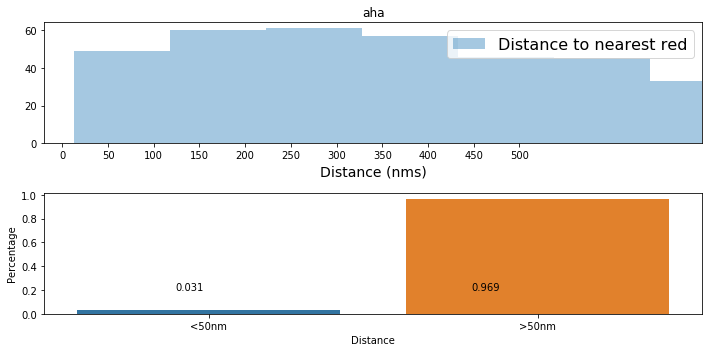

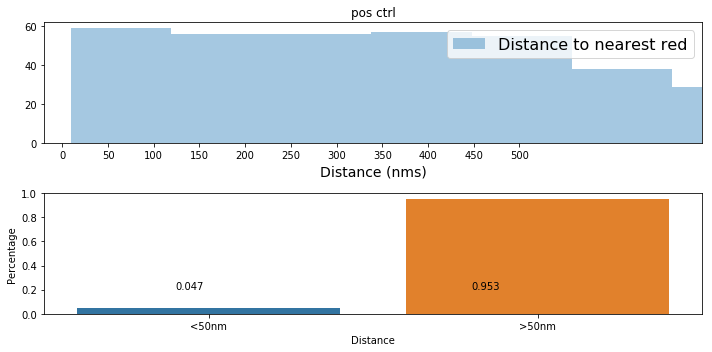

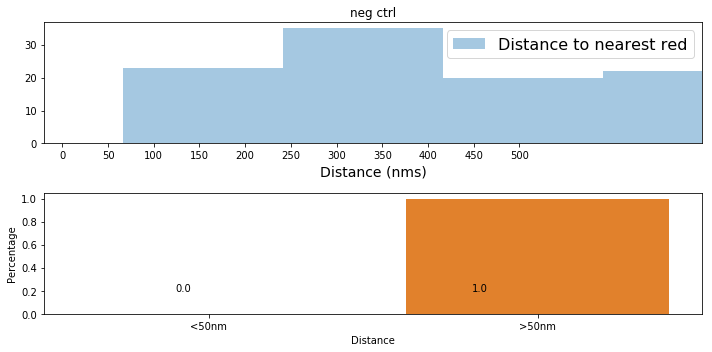

In [85]:
for protein in df_ecm["Protein"].unique():
    #df2plot=df_ecm[(df_ecm["Treatment"]=="Unblocked Control")&(df_ecm["Protein"]==protein)]
    df2plot=df_ecm[(df_ecm["Protein"]==protein)]
    fig=plt.figure(figsize=(10,5))
    fig.add_subplot(211)
    g=sns.distplot(df2plot["distance to nearest funcat centroid [nms]"],label="Distance to nearest red",kde=False)
    g.set_xticks(np.linspace(0,500,11))
    g.set_xlim([-20,700])
    plt.legend(fontsize=16)
    g.set_xlabel('Distance (nms)',fontsize=14)
    plt.title(protein)
    
    fig.add_subplot(212)
    dfcount=df2plot.groupby("Distance to funcat").count()
    if len(dfcount["filename"].unique())!=1:
        smallerthan=dfcount["filename"].unique()[0]
        biggerthan=dfcount["filename"].unique()[1]
    else:
        biggerthan=dfcount["filename"].unique()[0]
        smallerthan=0
    propsmaller=smallerthan/(smallerthan+biggerthan)
    propbigger=biggerthan/(smallerthan+biggerthan)
    dfprops={'Distance':['<50nm','>50nm'],'Percentage':[propsmaller,propbigger]}
    dfprops=pd.DataFrame(dfprops)
    sns.barplot(x="Distance",y="Percentage",data=dfprops)
    plt.text(x=-0.1,y=0.2,s=np.round(propsmaller,3))
    plt.text(x=0.8,y=0.2,s=np.round(propbigger,3))
    
    
    fig.tight_layout()

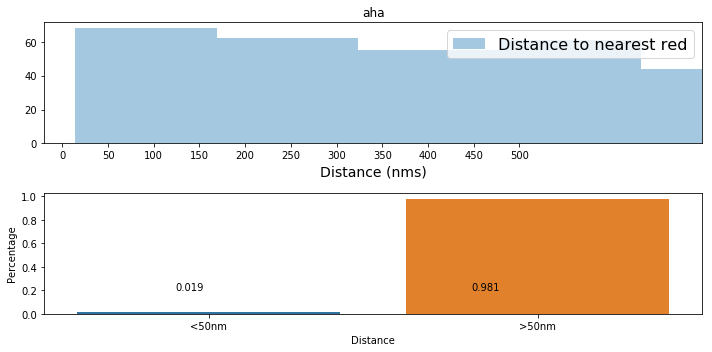

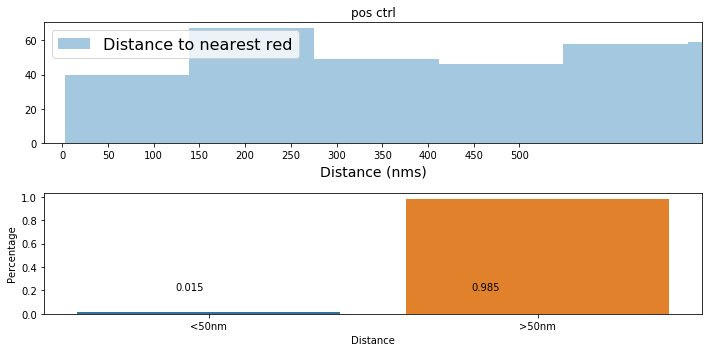

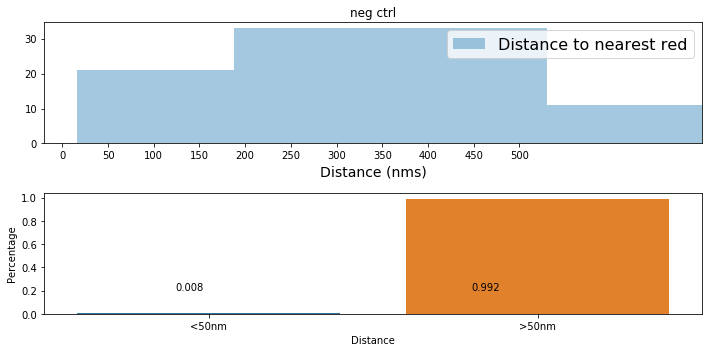

In [86]:
for protein in df_ecm["Protein"].unique():
    #df2plot=df_ecm[(df_ecm["Treatment"]=="Unblocked Control")&(df_ecm["Protein"]==protein)]
    df2plot=df_ecm[(df_ecm["Protein"]==protein)]
    fig=plt.figure(figsize=(10,5))
    fig.add_subplot(211)
    g=sns.distplot(df2plot["distance to nearest autofluorescence centroid [nms]"],label="Distance to nearest red",kde=False)
    g.set_xticks(np.linspace(0,500,11))
    g.set_xlim([-20,700])
    plt.legend(fontsize=16)
    g.set_xlabel('Distance (nms)',fontsize=14)
    plt.title(protein)
    
    fig.add_subplot(212)
    dfcount=df2plot.groupby("Distance to autofluorescence").count()
    if len(dfcount["filename"].unique())!=1:
        smallerthan=dfcount["filename"].unique()[0]
        biggerthan=dfcount["filename"].unique()[1]
    else:
        biggerthan=dfcount["filename"].unique()[0]
        smallerthan=0
    propsmaller=smallerthan/(smallerthan+biggerthan)
    propbigger=biggerthan/(smallerthan+biggerthan)
    dfprops={'Distance':['<50nm','>50nm'],'Percentage':[propsmaller,propbigger]}
    dfprops=pd.DataFrame(dfprops)
    sns.barplot(x="Distance",y="Percentage",data=dfprops)
    plt.text(x=-0.1,y=0.2,s=np.round(propsmaller,3))
    plt.text(x=0.8,y=0.2,s=np.round(propbigger,3))
    
    
    fig.tight_layout()